# Technical extension - Impact of wealth on eating habits in Greater London

In [1]:
import os
import math
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## 1) Data preparation

In this part, we will load and prepare the datasets. First we load 2015 MSOA tesco 1.0 dataset and official London MSOA 2015 dataset. 

We add to tesco 1.0 dataset a wealth category calculated using KMeans clustering on total median annual household income. Since we will study distribution of nutrients whithin each area, we also calculate fraction of each nutrient weight for each area. We validate this calculation by computing the field `h_nutrient_weight` with them, we should obtain same as the authors.

###  A) Load datasets

#### Let's get the 2015 MSOA Tesco 1.0 dataset and the official London MSOA 2015 dataset (you can find a full description in the README).

In [2]:
root = "data/"
tesco_msoa_path = os.path.join(root,"year_msoa_grocery.csv")
msoa_profile_path = os.path.join(root,"msoa-data.csv")

In [3]:
tesco_msoa_df = pd.read_csv(tesco_msoa_path)
msoa_profile_df = pd.read_csv(msoa_profile_path,encoding = "ISO-8859-1")

In [4]:
print("Shape of tesco_msoa_df:", tesco_msoa_df.shape)
tesco_msoa_df.head(3)

Shape of tesco_msoa_df: (983, 202)


,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794


In paper dataset, we have 201 nutrition related features and 983 msoa areas.

In [5]:
print('Shape of msoa_profile_df:', msoa_profile_df.shape)
msoa_profile_df.head(3)

Shape of msoa_profile_df: (984, 207)


,Middle Super Output Area,MSOA Name,Age Structure (2011 Census);All Ages;,Age Structure (2011 Census);0-15;,Age Structure (2011 Census);16-29;,Age Structure (2011 Census);30-44;,Age Structure (2011 Census);45-64;,Age Structure (2011 Census);65+;,Age Structure (2011 Census);Working-age;,Mid-year Estimate totals;All Ages;2002,...,Road Casualties;2010;Slight,Road Casualties;2010;2010 Total,Road Casualties;2011;Fatal,Road Casualties;2011;Serious,Road Casualties;2011;Slight,Road Casualties;2011;2011 Total,Road Casualties;2012;Fatal,Road Casualties;2012;Serious,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total
0,E02000001,City of London 001,7375,620,1665,2045,2010,1035,5720,7280,...,334,374,0,46,359,405,2,51,361,414
1,E02000002,Barking and Dagenham 001,6775,1751,1277,1388,1258,1101,3923,6333,...,18,18,0,2,16,18,0,1,15,16
2,E02000003,Barking and Dagenham 002,10045,2247,1959,2300,2259,1280,6518,9236,...,34,37,1,4,40,45,0,3,47,50


In official ward dataset, we have 207 different features about official statistics of each ward. We observe there are 984 msoa areas.

#### Now we will load geographic data of MSOAs for geovisualization.

In [6]:
msoa_map_path = os.path.join(root,"London","ESRI","MSOA_2011_London_gen_MHW.shp")
msoa_map_df = gpd.read_file(msoa_map_path)
print("Shape of msoa_map_df:", msoa_map_df.shape)
msoa_map_df.head(3)

Shape of msoa_map_df: (983, 13)


,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18..."


This dataset presents the localization of 983 msoa areas.

Text(0.5, 1.0, 'Geographic map of Greater London with MSOA boundaries')

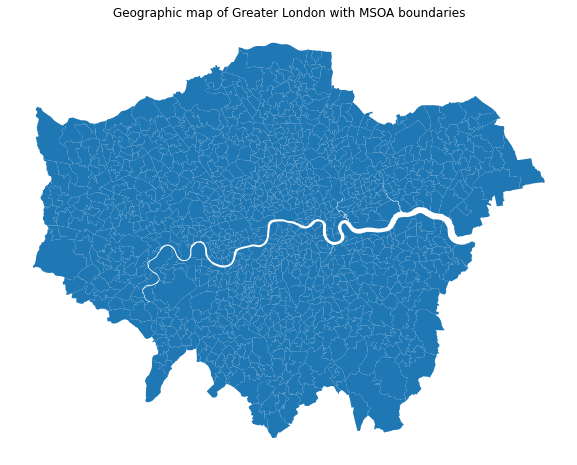

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.axis("off")
msoa_map_df.plot(ax=ax)
plt.title("Geographic map of Greater London with MSOA boundaries")

### B) Prepare datasets

To represent wealth of a MSOA area, we choose the median income as it has a better representativeness than the mean and is more robust to outliers.

In [8]:
# merge the median income to our main dataframe
official_useful_features = ["Household Income Estimates (2011/12);Total Median Annual Household Income (£);",
                            "Middle Super Output Area"]
main_df = tesco_msoa_df.merge(msoa_profile_df[official_useful_features],
                              left_on="area_id",right_on="Middle Super Output Area")

# Rename the column representing median income to shorter name
main_df = main_df.rename(columns={"Household Income Estimates (2011/12);Total Median Annual Household Income (£);":
               "median_income"}).drop(columns=["Middle Super Output Area"])
main_df.head(3)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,median_income
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,46788
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704,27059
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,36835


#### As in the Tesco paper, let's filter the msoa that have representativeness norm lesser than a threshold = 0.1

In [9]:
ini_data_size = main_df.shape[0]
main_df = main_df[ main_df['representativeness_norm'] >= 0.1 ]

Let's quickly check how much data we discard with this threshold:

In [10]:
repr_data_size = main_df.shape[0]
prop = (ini_data_size-repr_data_size)/ini_data_size
print('With the chosen threshold we drop {:.2f}% of the msoa data'.format(prop*100))

With the chosen threshold we drop 9.87% of the msoa data


#### We add a f_{nutrient} field for each main nutrient: carb, fat, fibre, protein and alcohol

We will use these features to correlate wealth with distribution of nutrients per area.
We use the equation below:

$f_{nutrient_i}(a) = \frac{nutrient_i(a)}{\sum_j nutrient_j(a)}$

In [11]:
nutrients = ["fat","carb","fibre","protein","alcohol"]
sum_df = main_df[nutrients].sum(1)
for n in nutrients:
    main_df["f_"+n]=main_df[n]/sum_df
main_df.head(2)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,age_65+,avg_age,area_sq_km,people_per_sq_km,median_income,f_fat,f_carb,f_fibre,f_protein,f_alcohol
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,1320.0,43.910124,2.90,2305.862069,46788,0.269292,0.501460,0.051479,0.166941,0.010828
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,1078.0,35.567286,2.16,3416.203704,27059,0.252452,0.556163,0.045393,0.140914,0.005079


Let's validate the calculation by computing the nutrient weight entropy, it should ba same as `h_nutrient_weigh` already in the dataset.

In [12]:
features = ["f_"+x for x in nutrients]

#entropy formulae from the Tesco paper (16)
entropy = -(main_df[features]*np.log2(main_df[features])).sum(1)

assert(np.sum(np.abs(entropy - main_df["h_nutrients_weight"]) > 1e-11) == 0)
#So our calculation is correct

### C) Cluster income levels using K-means

In this part, we labelize wealth category given the median income. To do so, we use K-means technique to minimize the intra-cluster variance and maximize the inter-cluster variance.

In [13]:
# Init a small dataframe with only median income and area_id (lighter to work on)
income_repr_msoa_df = main_df[['area_id','median_income']]

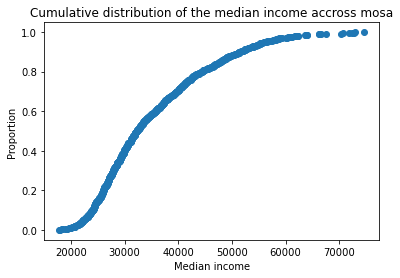

In [14]:
# Let's first plot the CDF of the incomes in MSOA
income_repr_msoa_df_sorted = income_repr_msoa_df.sort_values(by='median_income').reset_index(drop=True)
x_index_range=np.arange(0,income_repr_msoa_df.shape[0])/income_repr_msoa_df.shape[0]

plt.scatter(income_repr_msoa_df_sorted['median_income'],x_index_range)
plt.title("Cumulative distribution of the median income accross mosa")
plt.xlabel("Median income")
plt.ylabel("Proportion")
plt.show()

Now let's visualize different K-means clusterings we can get with K in [2,10]

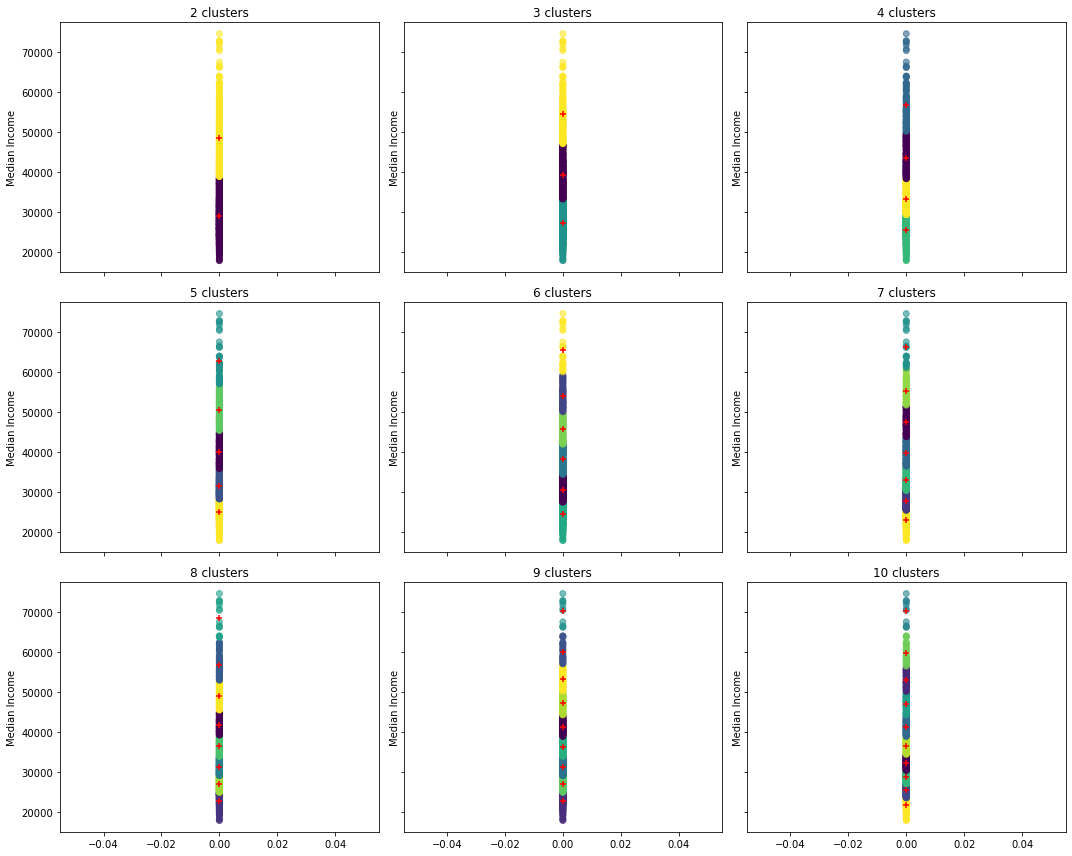

In [15]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

median_income = np.array(income_repr_msoa_df_sorted['median_income']).reshape(-1, 1)
x = np.zeros(median_income.shape[0])

# Compute number of row and columns for the graphs
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS-MIN_CLUSTERS)/COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(15,12), sharey=True, sharex=True)

#store values of enertia to better choose the number of clusters
inertias=[]

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    current_column = (n_clusters-MIN_CLUSTERS)%COLUMNS
    current_row = (n_clusters-MIN_CLUSTERS)//COLUMNS
    
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(median_income)
    
    #store the inertia
    inertias.append(kmean.inertia_)
    
    # Plot the data by using the labels as color
    ax.scatter(x, median_income, c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters"%n_clusters)
    ax.set_ylabel("Median Income")
    
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(0, c, marker="+", color="red")
        
plt.tight_layout()

Also let's plot the inertia to better decide on the number of clusters.

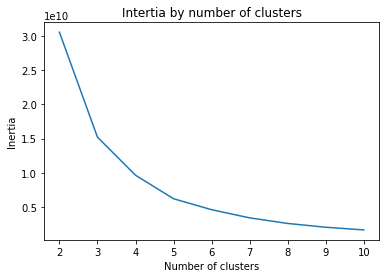

In [16]:
plt.plot(np.arange(MIN_CLUSTERS, MAX_CLUSTERS+1),inertias)
plt.title("Intertia by number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

5 clusters seems to separate the data fairly well and allow enough classes for our comparisons.

Let's give the following labels:  
Median income = {0=`very_low`, 1=`low`, 2=`medium`, 3=`high`, 4=`very_high`}

We can now include back in our main dataframe the cluster class of each MSOA:

In [17]:
CHOSEN_CLUSTER_NB = 5
wealth_class_labels = ['very_low', 'low', 'medium', 'high', 'very_high']

# Run k-means with the chosen number of clusters
data = np.array(income_repr_msoa_df['median_income']).reshape(-1, 1)
kmean = KMeans(n_clusters=CHOSEN_CLUSTER_NB).fit(data)

# Since the method does not return the labels sorted by increasing median_come we need to map them correctly
# Transforming the labels through a lookup table is a straightforward way to sort kmeans' labels
idx = np.argsort(kmean.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(CHOSEN_CLUSTER_NB)
labels = lut[kmean.labels_]

cluster_map = pd.DataFrame()
cluster_map['area_id'] = income_repr_msoa_df['area_id']
cluster_map['median_income'] = income_repr_msoa_df['median_income']
cluster_map['wealth_class'] = labels

print('Let\'s have a look at our median income cluster centers: \n', kmean.cluster_centers_)
cluster_map.head(3)

Let's have a look at our median income cluster centers: 
 [[31542.27272727]
 [50292.96774194]
 [24894.70106762]
 [40038.98378378]
 [62458.81395349]]


,area_id,median_income,wealth_class
0,E02000001,46788,3
1,E02000002,27059,0
2,E02000003,36835,2


In [18]:
main_df = main_df.merge(cluster_map[["area_id", "wealth_class"]],
                              left_on="area_id",right_on="area_id")
main_df.head(3)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,avg_age,area_sq_km,people_per_sq_km,median_income,f_fat,f_carb,f_fibre,f_protein,f_alcohol,wealth_class
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,43.910124,2.90,2305.862069,46788,0.269292,0.501460,0.051479,0.166941,0.010828,3
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,35.567286,2.16,3416.203704,27059,0.252452,0.556163,0.045393,0.140914,0.005079,0
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,35.700466,2.14,5009.345794,36835,0.257446,0.562147,0.042665,0.132752,0.004991,2


## 2) Visualization

In this part, we will get some intuition about the distribution of nutrient weight and purchased product types among MSOAs. First we will use T-SNE technique to spatial distribution of these features and see if there are similarities between features of same wealth class MSOAs. Then for nutrient distribution, we will geovisualize the distribution to see if there is any geographic pattern.

### A) T-SNE visualization

Let us define a tsne_vis function.

In [19]:
def tsne_vis(df, features, title):
    """"
    Utility visualization function to plot a T-sne 2D projection
    
    Args:
        - df: the full dataframe we apply t-sne
        - features: the features we're intrested in for the t-sne projection
        - title: the title of the plot
    """
    #Computes t_sne for features given as argument, we get 2D coordinates for each point
    tsne = TSNE(n_components=2,init='pca').fit_transform(df[features])
    plt.figure(figsize=(6, 5))
    labels = df.wealth_class.to_numpy()
    target_ids = np.unique(labels)
    
    #For 5 class, we have 5 colors
    colors = 'r', 'g', 'b', 'c', 'm'
    
    #For each label, we scatter the points with t-sne coordinate and corresponding color label
    for i, c, label in zip(target_ids, colors, wealth_class_labels):
        plt.scatter(tsne[labels == i, 0], tsne[labels == i, 1], c=c, label=label)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()

First, we set the vector of energy distribution between nutrients as first feature for each area.

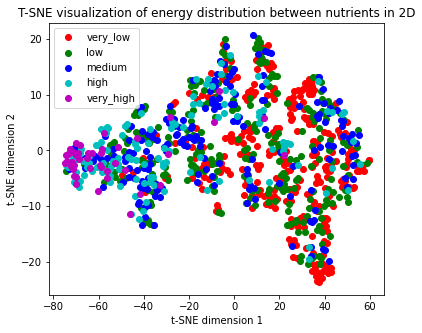

In [20]:
f_nutrients=["f_fat","f_fibre","f_protein",
          "f_carb","f_alcohol"]
tsne_vis(main_df, f_nutrients, "T-SNE visualization of energy distribution between nutrients in 2D")

We don't observe clear difference in eating habits between MSOAs except for the very_high that are clustered in the left. We hypothetize that these features are not good indicators of wealth.

Let's try with another feature, the distribution of dishes type bought by the customers and fraction of total product weight given by each product type.

In [21]:
feats = []
feats_weight = []
# We select the columns corresponding to the fractions of products types as well as their weight fractions
for col in main_df.columns:
    # Here we focus on products types so we do not include energy and nutrients
    if "f_" in col and "energy" not in col and col not in f_nutrients:
        if "weight" in col:
            feats_weight.append(col)
        else:
            feats.append(col)
print("We run the t-SNE on", len(feats), 
      "features which are all fractions of products types.")
print("We run the t-SNE on", len(feats_weight), 
      "features which are all weight fractions of products types.")

We run the t-SNE on 17 features which are all fractions of products types.
We run the t-SNE on 11 features which are all weight fractions of products types.


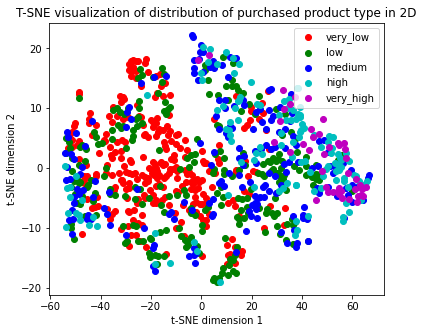

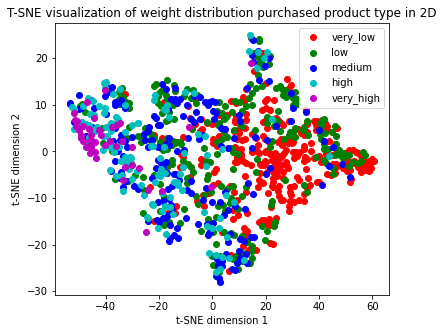

In [22]:
tsne_vis(main_df, feats,"T-SNE visualization of distribution of purchased product type in 2D")
tsne_vis(main_df, feats_weight,"T-SNE visualization of weight distribution purchased product type in 2D")

Again the clustering effect is only not very visible for non-extreme classes
Very-low and very-high cluster a little better and are fairly separated, giving us an intuition that indeed there might be different eating habits between the these two classes. We note that merging high and very_high would still not overalp with very_low cluster in both T-SNE.

### B) London choropleth map

First we will visualize the fraction of each nutrient at msoa level. Let's define a function to output a choropleth map. 

We will set in grey color the MSOA with low representativeness so that they can be better differentiated from the "valid" areas.

In [23]:
def london_vis(geo_map, data_df, ax, variable, geo_map_index="MSOA11CD", data_df_index="area_id"):
    """
    Utility visualization function to plot the Upper London map with per region levels
    
    Args:
        - geo_map : the London MSOA map dataframe
        - data_df : the dataframe with all features to display
        - ax : the axis of the plot to display on
        - variable : the name of the current feature we display on the map
        - geo_map_index : the name of the area index in the geo_map dataframe 
        - data_df_index : the name of the area index in the data_df dataframe 
    """
    # merge the two given df using their index label arguments
    merged_df = geo_map.merge(data_df,left_on=geo_map_index,right_on=data_df_index, how="left")
    
    #set the background background to grey for the missing values
    merged_df.plot(ax=ax,color="lightgrey")
    
    merged_df.plot(ax=ax,column=variable, cmap='Blues',linewidth=0.2,edgecolor='0.8',legend=True)
    ax.annotate('Source: London Datastore, 2014 and Tesco 1.0 dataset',xy=(0.1, .08),  
                xycoords='figure fraction', horizontalalignment='left', 
                verticalalignment='top', fontsize=12, color='#555555')
    ax.set_title("Comparison of {:s} between each MSOA of Greater London".format(variable))

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

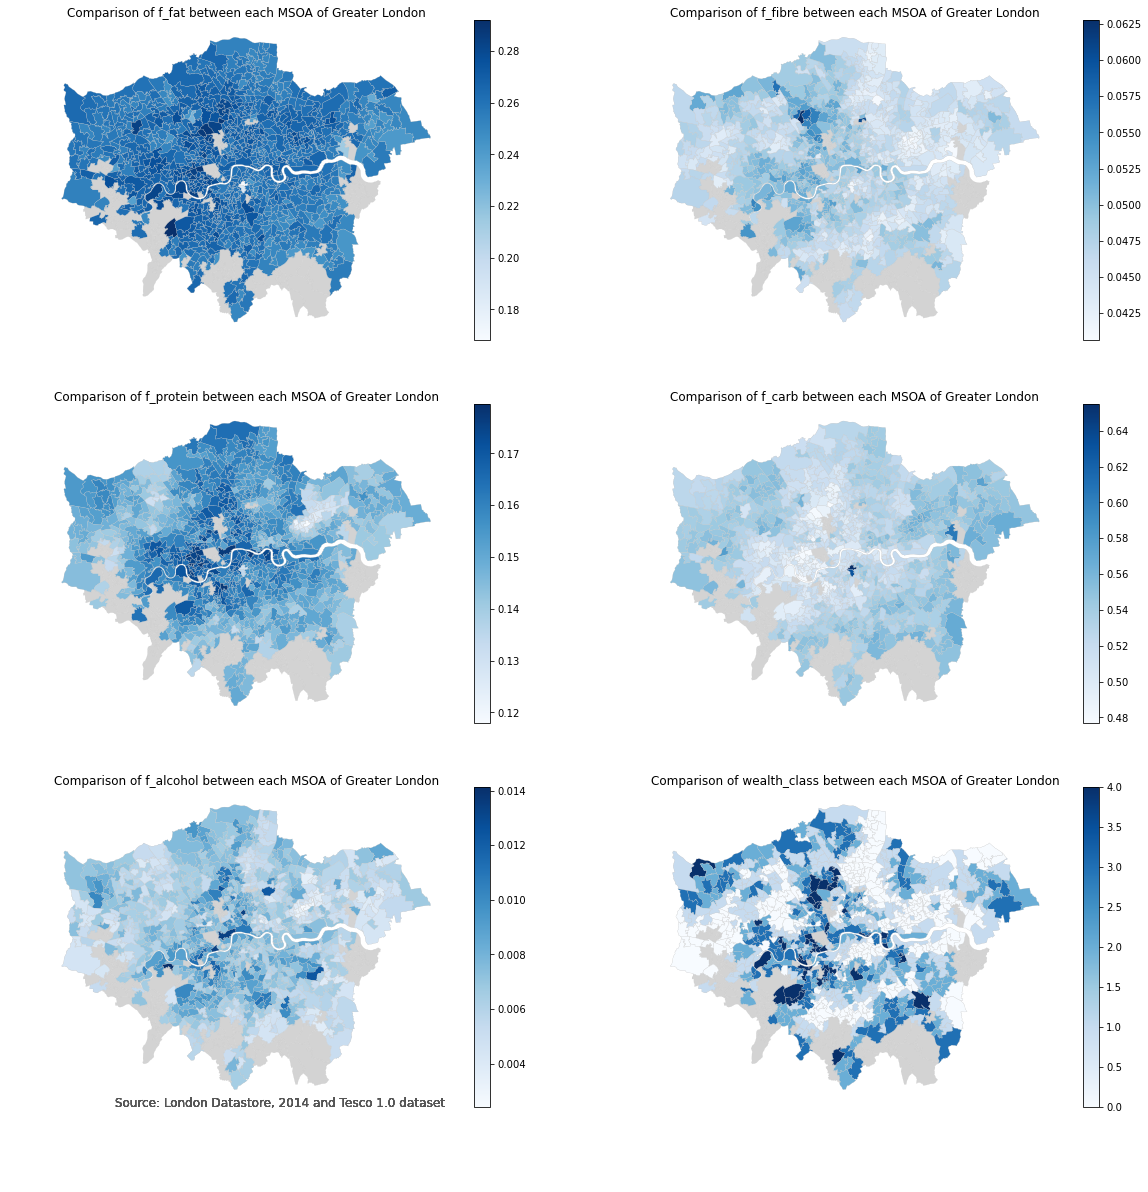

In [24]:
fig, ax = plt.subplots(3,2, figsize=(20,20))

for ax_,feat in zip(ax.reshape(-1), f_nutrients+["wealth_class"]):
    df_feats = ["area_id"]+[feat]
    london_vis(msoa_map_df, main_df[df_feats],ax_,feat)
    ax_.axis("off")
plt.plot

We don't observe clear geographic patterns in these plots. In center of London, we observe that where protein proportion is higher then sugar proportion is lower but is does not correspond to wealth indicator patterns. As T-SNE, this visulization is not indicative of a corrlation between wealth indicator and distribution of nutrients.
Since this visualization makes observation hard, we will not use it for product type fraction features.

### C) Other visualization

Now, we are interested in digging further for purchased product type distribution. Let us plot a heatmap which will show for each wealth class the mean weight fraction of each product type purchased. We also add the normalized entropy of weight of food product categories as wealth indicator, high entropy would mean "eating well".  
For all product not having a weight fraction feature, we show the product fraction feature instead. 

First, we define a heatmap visualization function.

In [25]:
def heatmap_vis(main_df, features, classes, ylabel, xlabel, title):
    """
    The function plots a heatmap given wealth classes and features. For each class and each feature,
    it computes the average feature value among all elements within the class.
    
    Args:
        - main_df : the pandas dataframe having a wealth_class and the features
        - features : the list of features to evaluate
        - classes : the wealth class labels
        - ylabel : the y label for the heatmap
        - xlabel : the x label for the heatmap
        - title  : the title of te heatmap
    """
    #Init grid
    grid=np.zeros((len(classes),len(features)))

    #populate the grid
    for wcl_i,wcl in enumerate(classes):
        by_wcl=main_df[main_df.wealth_class==wcl_i]
        for n_i,category in enumerate(features):
            grid[wcl_i,n_i]=by_wcl[category].mean()

    #Normalize between 0 and 1 to share same scale for each feature
    grid=(grid-grid.min(axis=0))/(grid.max(axis=0)-grid.min(axis=0))

    plt.subplots(figsize=(21, 3))
    ax=sns.heatmap(grid,xticklabels=features, yticklabels=classes)
    ax.set(ylabel=ylabel, xlabel=xlabel,title=title)
    plt.show()

Below, we extract categories name and use our function to plot the heatmap. We add normalized nutrient energy as wealth indicator.

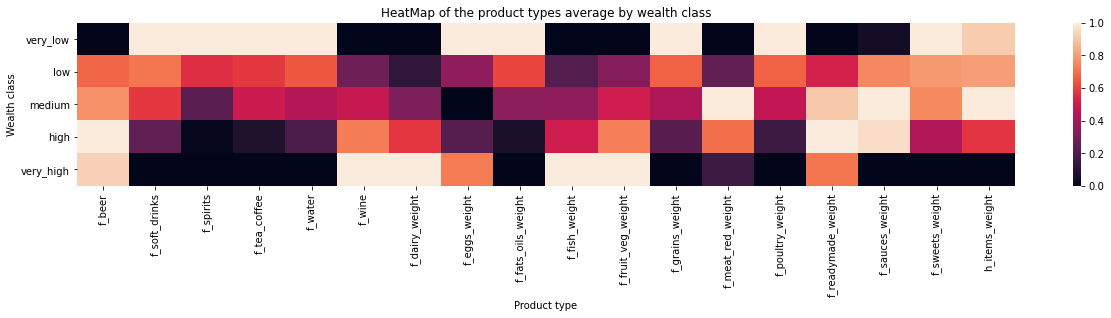

In [26]:
categories_names=[]
for c in main_df.columns:
    if c.startswith("f_") and "energy" not in c and c+"_weight" not in main_df.columns and c not in f_nutrients:
        categories_names.append(c)
categories_names.append("h_items_weight")
heatmap_vis(main_df, categories_names, wealth_class_labels, 
            "Wealth class", "Food product type", "HeatMap of the food product types average by wealth class")

We observe some nutrients are correlated with wealth class:

For example the comsumption of wine, fish, dairy products, fruit&vegetables and beer are correlated with high social class value.

Whereas the comsumption of soft drinks, spirits, grains, poultry and sweets are correlated with low social class value. 

Additionally we observe the entropy does not show wealth correlation.

Let's make the same visualization with distribution of nutrient weight, we also add the nutrient weight entropy as wealth indicator.

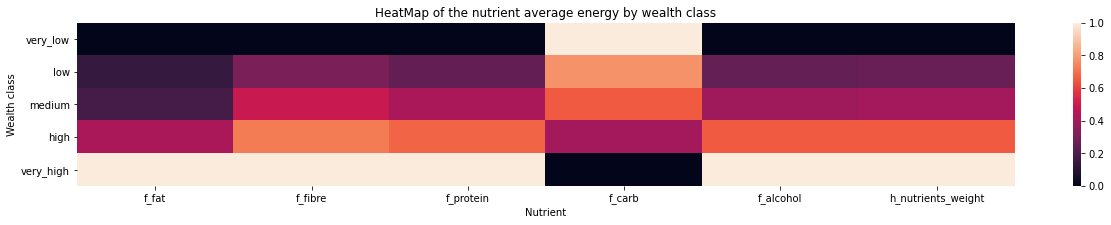

In [27]:
f_nutrients+=["h_nutrients_weight"]
heatmap_vis(main_df, f_nutrients, wealth_class_labels, 
            "Wealth class", "Nutrient", "HeatMap of the nutrient average energy by wealth class")

This heatmap gives us more information than the choropleth and t-sne visualization.
Some nutrients are correlated with wealth class:

We observe fat, fibre, protein, alcohol and the nutrients entropy are correlated with high wealth class wheras carb is correlated with low class value. Finally for fat, we don't observe clear correlation.

### D) Hypotheses

#### We make the following hypotheses:

a) We observed consumption of "healthy product" like fish and dairy products and fruit&vegetables are correlated with high social class value while "non healthy product" like soft drinks, spirits, sweets are correlated with low class value. So we make the hypothesis customers with high social class will likely buy bigger proportion of healthy product while customers with low class value will buy more unhealthy products.

b) In heatmap, we observed a correlation between "healthy nutrient" like fibre and protein with high class value. We observe a same correlation for the healthy marker "entropy of nutrients". We also observe a correlation between sugar and low social class. We make the hypothesis that sugars fractions are more important in lower class population and healthy nutrient fraction are more important in higher class population, thus showing a correlation between healthy eating habits and

wealth.

## 3) Hypotheses verification

To verify both hypotheses, we proced in two (TODO: or three) steps:

 a) We compare distribution of each feature within each class using hist plot
 
 b) We use spearman's rank correlation to show significant correlation between a feature and the median_income. We used the wealth_class for better vizualization, but now, since the wealth_class only depends on the median income we can use the continuous version to obtain a more precise estimate for the correlation.

 c) We use logistic regression to find which feature explain more a wealth class. #TODO explain more, not clear

#### We define utility functions for each part:

In [28]:
def a_hist_plots(main_df, categories_names, wealth_class_labels,plot_type='hist'):
    """
    The function plots a grid of histograms, each time ploting an histogram of the columns of the given
    dataframe whose name is in categories_names, for each differente wealth_class.
    
    Args:
        - main_df : the pandas dataframe having a wealth_class and the categories_names
        - categories_names : the list of categories to be ploted
        - wealth_class_labels : the wealth class labels
        - plot_type: the type of plot we want, either the histogram or its corresponding function estimates
    """
    #set the width of the grid to a constant
    width=4
    #set the vetiacl number of plot accordingly
    height=math.ceil(len(categories_names)/width)

    #set up the figure size
    f = plt.figure(figsize=(20,6*height))
    
    # the colors
    color_set=["#8ebad9","#ffbe86","#95cf95","#ea9293","#c9b2dd"]

    #iterate over the categories to consider
    for idx_c,c in enumerate(categories_names):
        #add a plot at the correct place
        ax= f.add_subplot(height,width,idx_c+1)
        #iterate over the wealth class
        for wc in range(len(main_df.wealth_class.unique())):
            #plot the histogram
            if plot_type=="hist":
                ax.hist(main_df[main_df.wealth_class==wc][c], alpha=0.5, label=wealth_class_labels[wc])
            elif plot_type=="kde":
                sns.kdeplot(main_df[main_df.wealth_class==wc][c],
                            label=wealth_class_labels[wc],ax=ax, color=color_set[wc])
            else:
                raise NotImplementedError
        
        plt.title("Histogram of the fraction of " + c[2:] + " by wealth class", size=9)
        plt.xlabel("fraction of " + str(c)[2:] )
        plt.ylabel("number of msoa")
        plt.legend()
    plt.show()

In [29]:
def b_spearman_rank(main_df, categories_names):
    """
    The function return a dataframe of the spearman rank correlation between the median_income and the food categories.
    
    Args:
        - main_df : the pandas dataframe having a column median_income and the categories_names
        - categories_names : the list of categories to checked for correlation with the median_income
    """   
    #initialise the dataframe
    spearman_df=pd.DataFrame(columns=["feature_name","coef","p_value","log10_p_value"])

    #compute all correlation
    for category in categories_names:
        # compute spearman's rank correlation
        coef, p = spearmanr(main_df["median_income"],main_df[category])
        #append the coefficient and p_values
        spearman_df=spearman_df.append(
            {"feature_name":category,"coef":coef,"p_value": p,"log10_p_value":int(np.ceil(np.log10(p)))}
            ,ignore_index=True)
    
    return spearman_df

In [30]:
def display_spearmanRank_textual(spearman_df):
    """
    The function prints a textual visualization of the given dataframe interpreted
    as the representation of spearman rank coefficients and the p-value.
    It only displays those that are statisticaly significant
    
    Args:
        - spearman_df : the pandas dataframe with the spearmanRank attributes
    """    
    SIGNIFICANT_THRESHOLD=0.05

    print("Following categories have a statisticaly significant correlation with the median income\n\n")
    print("First those that are positively correlated with median income\n")
    pos_corr=spearman_df[(spearman_df.p_value<SIGNIFICANT_THRESHOLD) 
                         & (spearman_df.coef>0)].sort_values(by='coef',ascending=False)
    for row in pos_corr.iterrows():
        print("- %18s have coefficient %+.2f with p value of order 10^%d"
              %(row[1].feature_name,row[1].coef,row[1].log10_p_value))

    print("\n\nNow those that are negatively correlated with median income\n")
    neg_corr=spearman_df[(spearman_df.p_value<SIGNIFICANT_THRESHOLD) 
                         & (spearman_df.coef<0)].sort_values(by='coef')
    for row in neg_corr.iterrows():
        print("- %18s have coefficient %+.2f with p value of order 10^%d"
              %(row[1].feature_name,row[1].coef,row[1].log10_p_value))

In [31]:
def display_spearmanRank_histogram(spearman_df):
    """
    The function prints a histogram visualization of the given dataframe interpreted
    as the representation of spearman rank coefficients and the p-value.
    It only displays those that are statisticaly significant
    
    Args:
        - spearman_df : the pandas dataframe with the spearmanRank attributes
    """    
    SIGNIFICANT_THRESHOLD=0.05
    
    coef=spearman_df.coef.copy()
    labels=spearman_df.feature_name
    p_values=spearman_df.p_value

    colors=['#2478A8' if coefficient>0 else '#E29638' for coefficient in coef]
    
    coef[p_values>=SIGNIFICANT_THRESHOLD]=np.nan

    plt.bar(labels,height=coef,color=colors)
    plt.grid(axis='y',fillstyle='none')
    plt.title("Spearman rank correlation between wealth class and food category")
    plt.ylabel("R")
    plt.xticks(rotation=90)
    plt.show()

In [32]:
def c_linear_regression(main_df, categories_names):
    """
    The function displays the olsmodel textual representation, trying to fit the median income
    from the features whose name are in categories_names.
    
    Args:
        - main_df : the pandas dataframe having a column median_income and the categories_names
        - categories_names : the list of categories
    """    
    #generate the fomula
    formula='median_income ~ '
    for nn in categories_names:
        formula+=(" + "+nn)

    #standardize the main_df before fitting the linear model
    #standardized_main_df=(main_df-main_df.mean())/main_df.std()
    standardized_main_df=main_df.copy()
    standardized_main_df["median_income"]=(standardized_main_df["median_income"]
                    -standardized_main_df["median_income"].min())/(standardized_main_df["median_income"].max()
                                                                -standardized_main_df["median_income"].min())

    #fit the linear model and display it
    ols_model = smf.ols(formula, data=standardized_main_df).fit()
    print(ols_model.summary())
    
    # feature names
    variables = ols_model.params.index

    # quantifying uncertainty!

    # coefficients
    coefficients = ols_model.params.values

    # p-values
    p_values = ols_model.pvalues

    # standard errors
    standard_errors = ols_model.bse.values
    
    #sort them all by coefficients
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')

    plt.yticks(range(len(l2)),l2)

#### Categories fraction study

#### a) histogram plot

Within each class, we compare distribution of some category fraction.

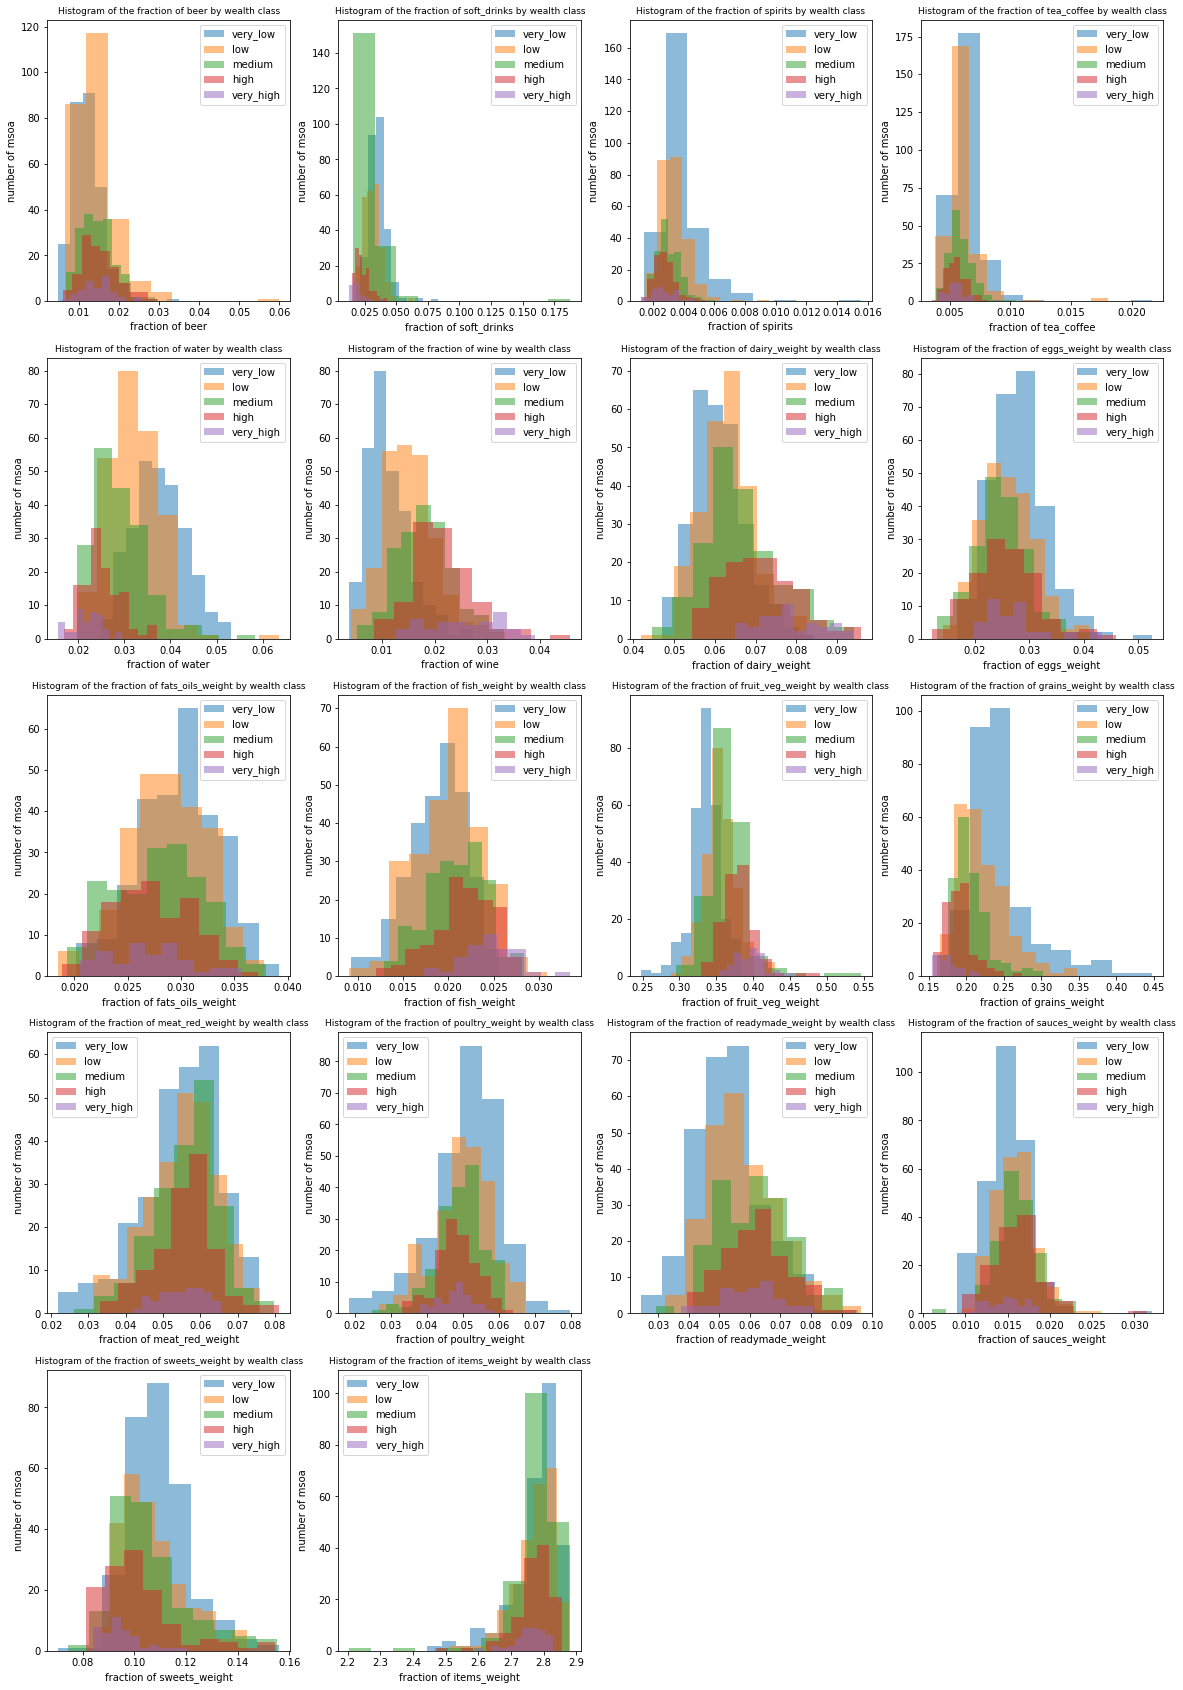

In [33]:
a_hist_plots(main_df, categories_names, wealth_class_labels,plot_type="hist")

Let's smooth the curves to see the distribution better

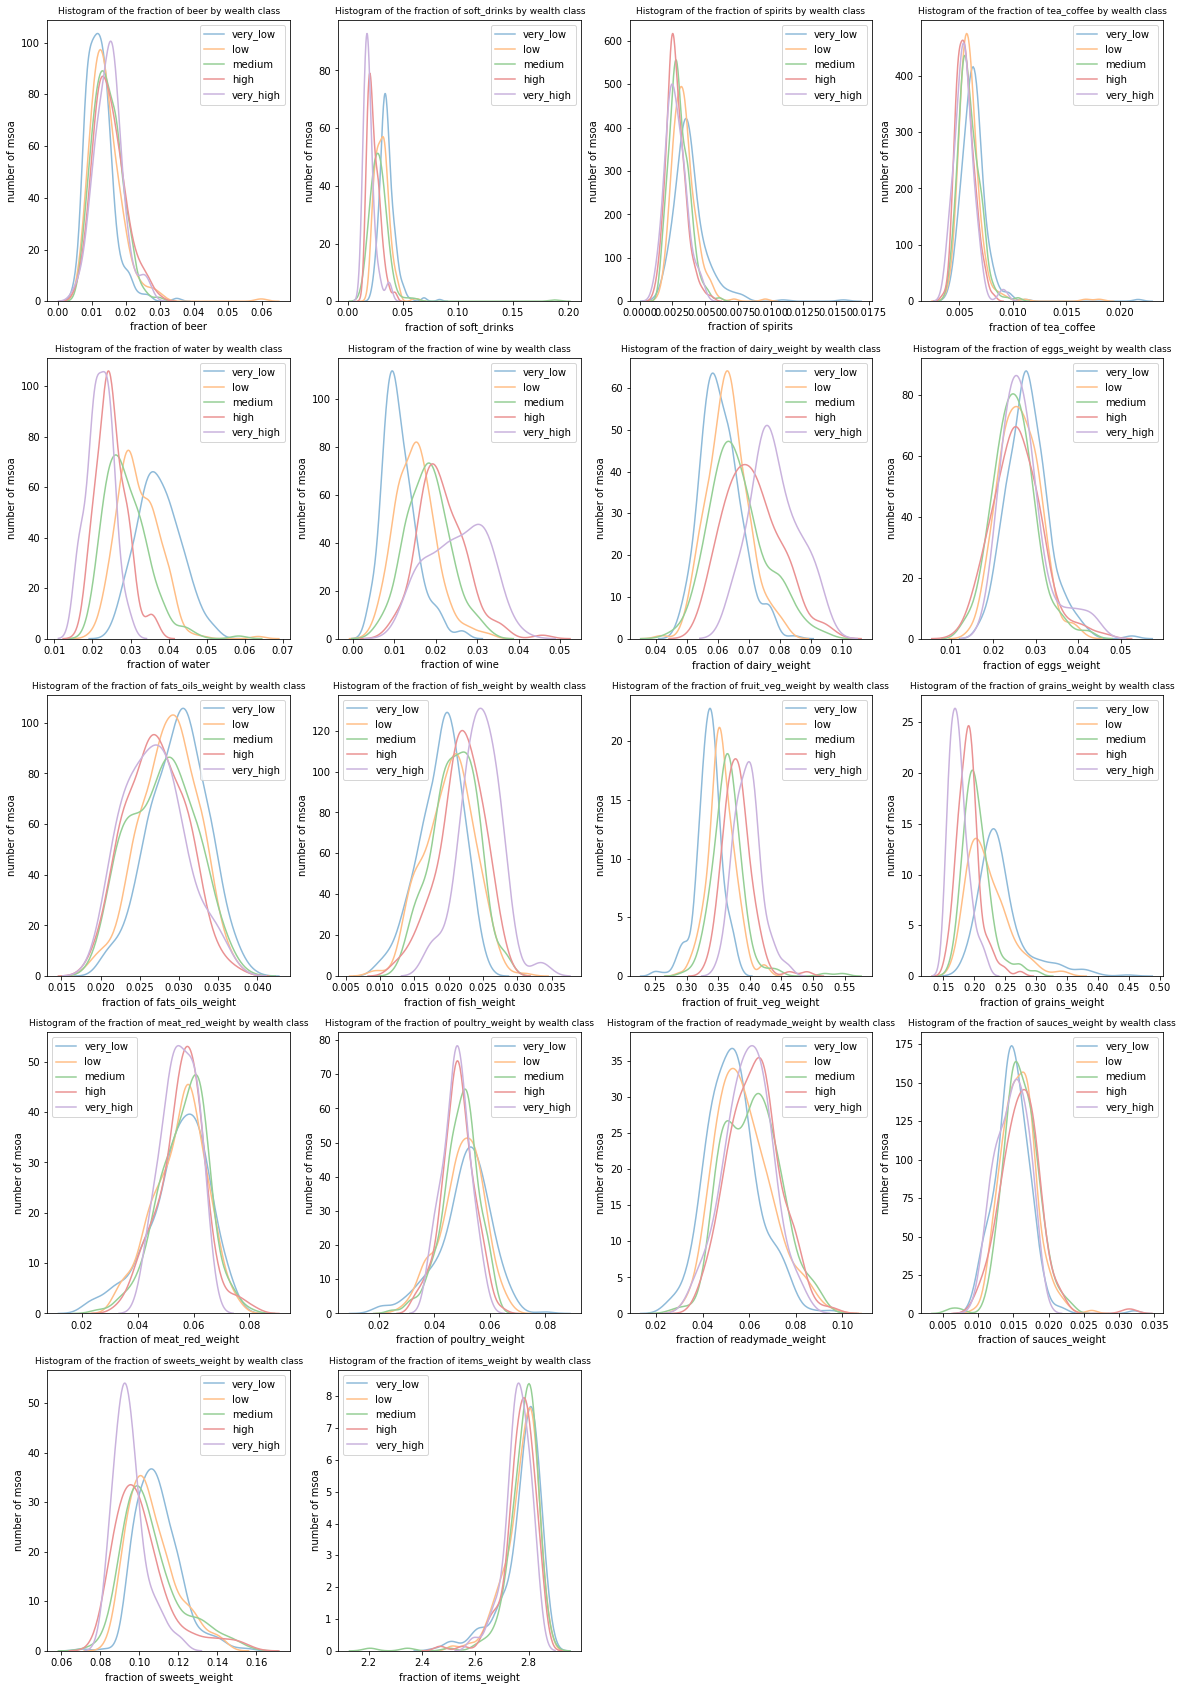

In [34]:
a_hist_plots(main_df, categories_names, wealth_class_labels,plot_type="kde")

We make same observations as in visualization part; wine, dairy weight, fish_weight, fruit&vegetable weight seem to be positvely correlated with wealth class while water, grains_weight, sweets_weight, soft drinks and spirits seem to be negatively correlated.

#### b) Spearman correlation

Let us verify this by computing spearman correlations with those features and the median income.

In [35]:
display_spearmanRank_textual(b_spearman_rank(main_df, categories_names))

Following categories have a statisticaly significant correlation with the median income


First those that are positively correlated with median income

- f_fruit_veg_weight have coefficient +0.66 with p value of order 10^-110
-             f_wine have coefficient +0.66 with p value of order 10^-109
-     f_dairy_weight have coefficient +0.44 with p value of order 10^-42
-      f_fish_weight have coefficient +0.35 with p value of order 10^-25
- f_readymade_weight have coefficient +0.32 with p value of order 10^-22
-             f_beer have coefficient +0.29 with p value of order 10^-18
-    f_sauces_weight have coefficient +0.17 with p value of order 10^-6


Now those that are negatively correlated with median income

-            f_water have coefficient -0.72 with p value of order 10^-139
-    f_grains_weight have coefficient -0.63 with p value of order 10^-98
-      f_soft_drinks have coefficient -0.62 with p value of order 10^-93
-          f_spirits have coefficient -0.41 with p v

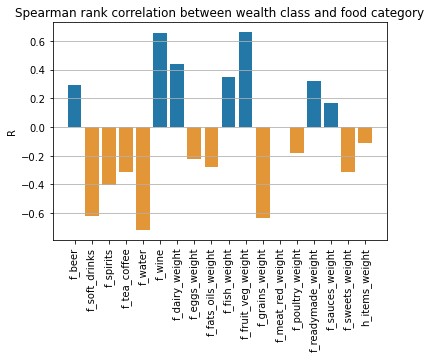

In [36]:
display_spearmanRank_histogram(b_spearman_rank(main_df, categories_names))

All above correlations are statistically significant. We note strong postitive correlation between wealth class and both fruit&vegetables, dairy, fish which are markers of healthy eating habits. We note strong negative correlation between wealth class and sweets, soft drinks which are marker of unhealty eating habits.

We also note a strong positive correlation for wine and negative correlation for water.
We can only make hypothesis about this strong correlation, the most likely one that we could think of is that the amount of water bought does not vary significanlty but because the wealthier population buys more products then the fraction of them represented by water is reduced. About wine, is it not surprising that, as it is wealthy product, its consumption is correlated with the median income.

#### c) logistic regression

Finally we use logistic regression to estimate the median income with food categories and entropy. 

We want to know if we can predict the median income with fraction of purchased healthy and unhealthy product type.
For this we use linear regression and measure the R-squared value 

For healthy product, we select fruit&vegetable, dairy and fish. For unhealthy product, we select sweets, sauces and soft drinks.

                            OLS Regression Results                            
Dep. Variable:          median_income   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     88.81
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          1.78e-176
Time:                        19:11:19   Log-Likelihood:                 655.77
No. Observations:                 886   AIC:                            -1276.
Df Residuals:                     868   BIC:                            -1189.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.2829      1

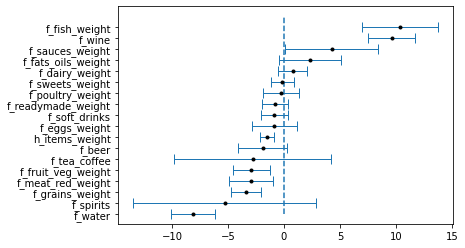

In [37]:
c_linear_regression(main_df, categories_names)

With a linear model we can explain around 63% of the variance which is reasonable.

We notice analogous result as above (only considering the most statisticaly significant measure):
    - wine,fish weight,fruit&vegetable weights are positively correlated with the median income
    - water,beer,egg weight,red meat weight are negatively correlated with the median income

#### Nutrients distribution study

Let's now look at the nutrient instead of the food category.

#### a) Histogram visualization

We procede the same way, let us visualize the different nutrient distribution.

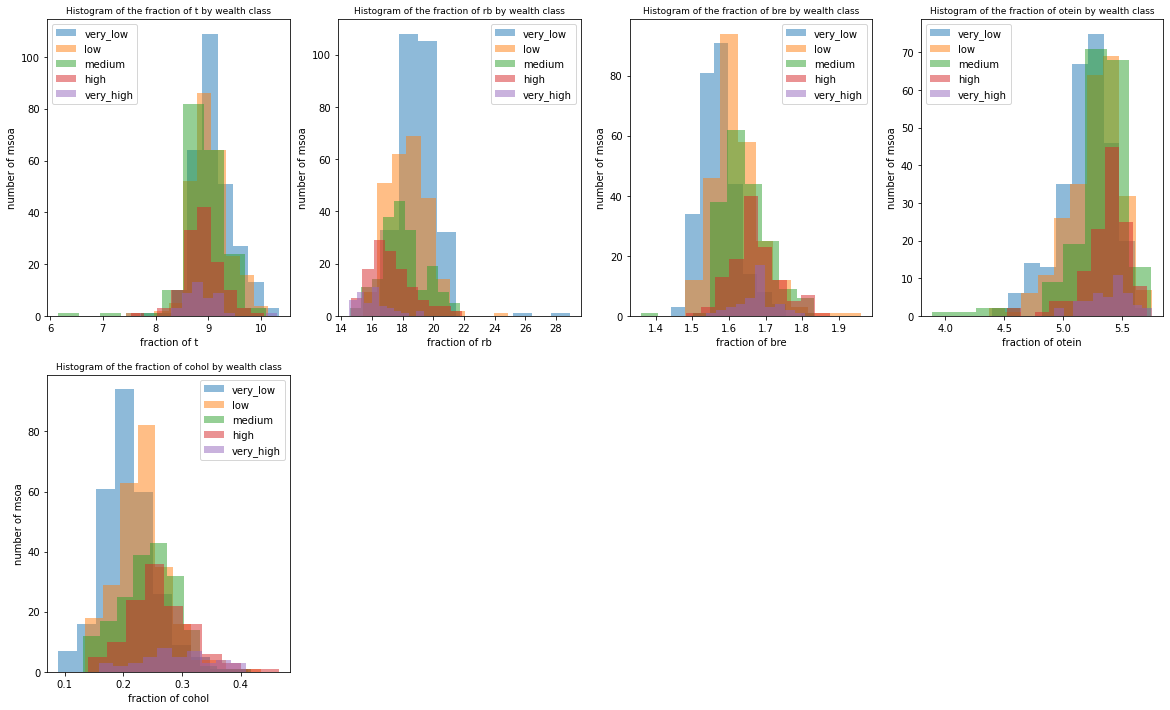

In [38]:
a_hist_plots(main_df, nutrients, wealth_class_labels)

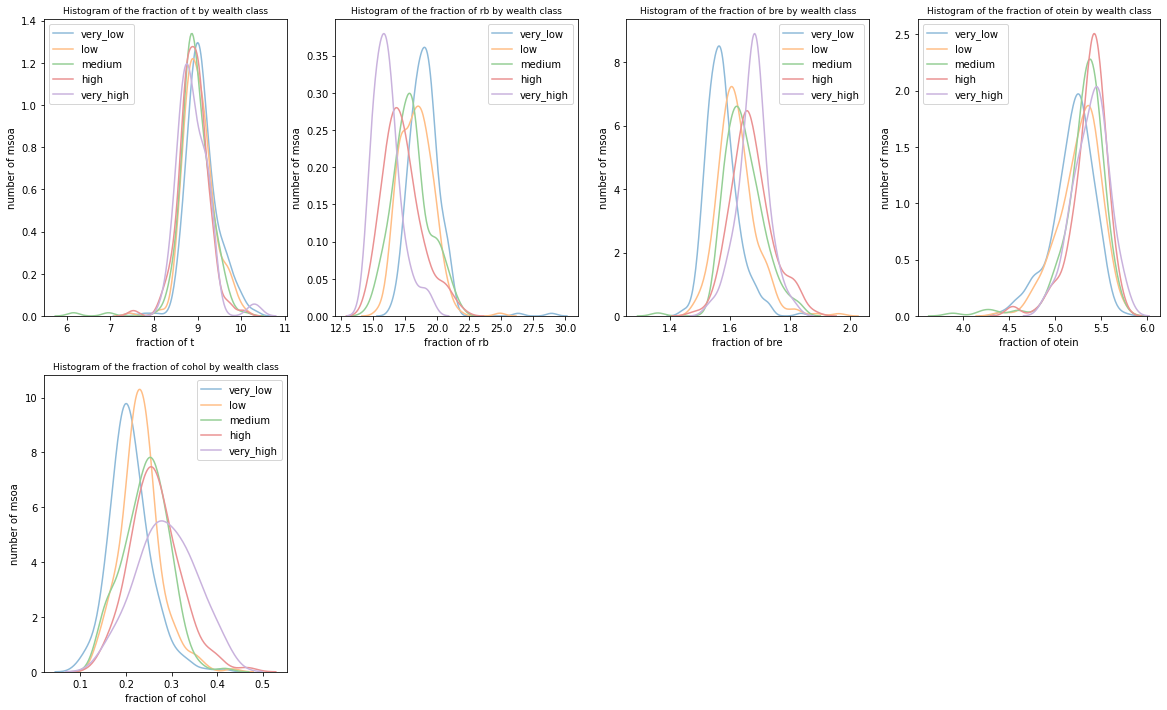

In [39]:
a_hist_plots(main_df, nutrients, wealth_class_labels, plot_type="kde")

It seems there are positive correlations with entropy, alcohol, fibre, fat and protein.  
On the other side, there seems to be a negative correlation with carb.

#### b) spearman correlation

Let's validate our observations with spearman correlation.

In [40]:
nutrients=['f_fat','f_carb','f_protein','f_fibre','f_alcohol','h_nutrients_weight']
b_spearman_rank(main_df, nutrients)

,feature_name,coef,p_value,log10_p_value
0,f_fat,0.316636,4.403341e-22,-21
1,f_carb,-0.519139,2.695877e-62,-61
2,f_protein,0.475702,3.167164e-51,-50
3,f_fibre,0.732000,1.728335e-149,-148
4,f_alcohol,0.465179,8.931561e-49,-48
5,h_nutrients_weight,0.588325,1.277315e-83,-82


All correlations are statistically significant. We indeed note strong positive correlation between both fibre, entropy, protein, alcohol and fat with median income wheras we note negative correlation with carb.
TODO --> What are the conclusions ??

#### c) logistic regression

                            OLS Regression Results                            
Dep. Variable:          median_income   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     204.1
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          2.10e-144
Time:                        19:11:22   Log-Likelihood:                 550.40
No. Observations:                 886   AIC:                            -1089.
Df Residuals:                     880   BIC:                            -1060.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.1969      4

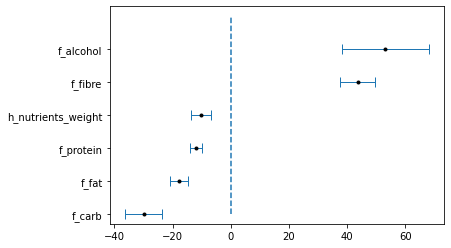

In [41]:
c_linear_regression(main_df, nutrients)

It seems that sugar and fat are negatively correlated with the median income. Whereas fibre, entropy and protein are positively correlated with the median income.

Note that the nurtient that are considered more healthy, such as fibre and protein as well as a variate alimentation (entropy of nurtients) are correlated to a higher median income.

Which could show that a wealthier population eats more healthily

# TODO: Conclusion and limitations

TODO